## 0 - Libraries

In [1]:
!pip install transformers timm lightning==2.0.1 --quiet
!sudo apt-get install unzip --quiet
!pip install gdown --quiet
!pip install pandas albumentations --quiet
!pip install matplotlib

Reading package lists...
Building dependency tree...
Reading state information...
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


In [2]:
import os
import csv
import timm
import torch
import requests
import itertools
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
from tqdm.auto import tqdm
import albumentations as A
import torch.nn.functional as F
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import lightning.pytorch as pl
import torch.optim as optim
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
import pickle
import matplotlib.pyplot as plt
import multiprocessing
multiprocessing.cpu_count()

16

Download movie posters

In [3]:
# !gdown 1-1b_eRIQ7bw2tpvC6jgag4moY7FCnMXD
# !unzip posterimages.zip

## 1 - Create Dataset

In [4]:
class CLIPDataset(torch.utils.data.Dataset):

  def __init__(self,image_filenames, captions, tokenizer, transforms):

    self.image_filenames = image_filenames
    self.captions = list(captions)
    self.encoded_captions  = tokenizer(list(captions), padding = True,
                              truncation=True, max_length = 200)
    self.transform = transforms

  def __len__(self):
    return len(self.captions)

  def __getitem__(self,idx):
    item = {
        key: torch.tensor(values[idx])
        for key, values in self.encoded_captions.items()
    }

    image = np.array(Image.open('/content/' + self.image_filenames[idx]).convert('RGB'))
    image = self.transform(image=image)['image']
    item['image']   = torch.tensor(image).permute(2,0,1).float()
    item['caption'] =  ' '.join(self.captions[idx].split('|'))
    item['url'] = self.image_filenames[idx]

    return item

def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.RandomResizedCrop(224, 224, scale=(0.8, 1.0), ratio=(0.75, 1.33), always_apply=True),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, always_apply=False, p=0.5),
                A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=2, min_height=8, min_width=8, fill_value=0, mask_fill_value=None, always_apply=False, p=0.5),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(224, 224, always_apply=True), # mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),
                A.Normalize( max_pixel_value=255.0, always_apply=True),
            ]
        )

In [5]:
# read movie database list
df = pd.read_csv('movie_genre2.csv')
df = df[~df.genre.isnull()]

movie_images_list  = df.images.to_list()
genre_list = df.genre.to_list()

In [28]:
tokenizer  = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
transforms = get_transforms(mode='train')
movieposter_dataset = CLIPDataset(image_filenames = movie_images_list, captions = genre_list,\
                                  tokenizer=tokenizer,transforms = transforms)
#split - train/val
train_dataset, val_dataset  = torch.utils.data.random_split(movieposter_dataset, [0.8, 0.2])

def prompt_collate(batch):
  input_ids_list , attention_masks_list, img_lists, image_urls_list, image_captions_list  = [],[],[],[],[]

  prompts = ['I would like to watch movies which are ','Show me movies ','Recommend movies that are ','Suggest movies ','Any recommendations for a movie ','Any movies of ']

  for b in batch:
    input_ids_list.append(b['input_ids'])
    attention_masks_list.append(b['attention_mask'])
    img_lists.append(b['image'])
    image_captions_list.append( np.random.choice(prompts) + b['caption'])
    image_urls_list.append(b['url'])

  return {
      "input_ids": torch.vstack(input_ids_list),
      "attention_mask": torch.vstack(attention_masks_list),
      "image": torch.stack(img_lists),
      "caption": image_captions_list,
      "url": image_urls_list
        }


# dataloader
# dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=32,num_workers=8,shuffle=True,collate_fn = prompt_collate)
val_dataloader   = torch.utils.data.DataLoader(val_dataset,batch_size=32,num_workers=8,shuffle=False,collate_fn = prompt_collate)

In [14]:
train_dataset[1]

{'input_ids': tensor([ 101, 4038, 1064, 3689,  102,    0,    0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 0, 0, 0, 0]),
 'image': tensor([[[1.6324, 1.6324, 1.6324,  ..., 1.6324, 1.6324, 1.6324],
          [1.6324, 1.6324, 1.6324,  ..., 1.6324, 1.6324, 1.6324],
          [1.6324, 1.6324, 1.6324,  ..., 1.6324, 1.6324, 1.6324],
          ...,
          [1.6324, 1.6324, 1.6324,  ..., 1.6324, 1.6324, 1.6324],
          [1.6324, 1.6324, 1.6324,  ..., 1.6324, 1.6324, 1.6324],
          [1.6324, 1.6324, 1.6324,  ..., 1.6324, 1.6324, 1.6324]],
 
         [[1.7983, 1.7983, 1.7983,  ..., 1.7983, 1.7983, 1.7983],
          [1.7983, 1.7983, 1.7983,  ..., 1.7983, 1.7983, 1.7983],
          [1.7983, 1.7983, 1.7983,  ..., 1.7983, 1.7983, 1.7983],
          ...,
          [1.7983, 1.7983, 1.7983,  ..., 1.7983, 1.7983, 1.7983],
          [1.7983, 1.7983, 1.7983,  ..., 1.7983, 1.7983, 1.7983],
          [1.7983, 1.7983, 1.7983,  ..., 1.7983, 1.7983, 1.7983]],
 
         [[2.0125, 2.0125, 2.

In [15]:
batch = next(iter(train_dataloader))
batch['input_ids'].shape, batch['attention_mask'].shape, batch['image'].shape,batch['caption'],len(batch['url'])

(torch.Size([32, 9]),
 torch.Size([32, 9]),
 torch.Size([32, 3, 224, 224]),
 ['I would like to watch movies which are Documentary',
  'I would like to watch movies which are Animation Family',
  'Any movies of Action Adventure Thriller',
  'Recommend movies that are Drama Music',
  'Recommend movies that are Comedy',
  'Suggest movies Drama Mystery Thriller',
  'Show me movies Drama Fantasy',
  'I would like to watch movies which are Drama',
  'Recommend movies that are Comedy Family Mystery',
  'Suggest movies Documentary Music',
  'Suggest movies Documentary History',
  'Any recommendations for a movie Horror',
  'I would like to watch movies which are Drama',
  'I would like to watch movies which are Action Drama Thriller',
  'I would like to watch movies which are Horror Thriller',
  'Suggest movies Musical Western',
  'Any movies of Drama',
  'I would like to watch movies which are Action Adventure Drama',
  'Show me movies Comedy',
  'Show me movies Action Comedy Crime',
  'Sugge

## 2 - Define CLIP Model

In [16]:
class ImageEncoder(nn.Module):
  def __init__(
      self
  ):
    super().__init__()
    self.model = timm.create_model('resnet50', pretrained = True,
                                   num_classes = 0, global_pool = 'avg')

    for p in self.model.parameters():
      p.requires_grad = False

  def forward(self,x):
    return self.model(x)

class TextEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = DistilBertModel.from_pretrained('distilbert-base-uncased')

    for p in self.model.parameters():
      p.requires_grad = False

  def forward(self,input_ids, attention_mask):
    output = self.model(input_ids=input_ids,attention_mask = attention_mask)
    last_hidden_state = output.last_hidden_state
    return last_hidden_state[:,0,:] # CLS TOKEN

class ProjectionHead(nn.Module):
  def __init__(
      self,
      embedding_dim,
      projection_dim = 256,
      dropout = 0.1
  ):
    super().__init__()
    self.projection = nn.Linear(embedding_dim,projection_dim)
    self.gelu       = nn.GELU()
    self.fc         = nn.Linear(projection_dim,projection_dim)
    self.dropout    = nn.Dropout(dropout)
    self.layer_norm = nn.LayerNorm(projection_dim)

  def forward(self,x):
    projected = self.projection(x)
    x = self.gelu(projected)
    x = self.fc(x)
    x = self.dropout(x)
    x = x + projected
    x = self.layer_norm(x)

    return x

In [17]:
class CLIPModel(nn.Module):
  def __init__(
      self,
      image_embedding = 2048,
      text_embedding  = 768
  ):
    super().__init__()
    self.image_encoder = ImageEncoder()
    self.text_encoder = TextEncoder()

    self.image_projection = ProjectionHead(embedding_dim=image_embedding)
    self.text_projection  = ProjectionHead(embedding_dim=text_embedding)


  def forward(self,batch):
    image_features = self.image_encoder(batch['image'].to('cuda'))
    text_features  = self.text_encoder(
        input_ids  = batch['input_ids'].to('cuda'),attention_mask = batch["attention_mask"].to('cuda')
    )
    image_embeddings = self.image_projection(image_features)
    text_embeddings = self.text_projection(text_features)

    return text_embeddings, image_embeddings

def loss_fn(text_embeddings,image_embeddings,temperature):
    logits = (text_embeddings @ image_embeddings.T) / temperature
    image_similarity = image_embeddings @ image_embeddings.T
    text_similarity  = text_embeddings @ text_embeddings.T

    targets = F.softmax(
        (image_similarity + text_similarity)/(2 * temperature), dim=-1
    )
    texts_loss  = cross_entropy(logits, targets)
    images_loss = cross_entropy(logits.T, targets.T)
    loss = (images_loss + texts_loss) / 2.0
    return loss.mean()

def cross_entropy(preds, targets):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (- targets * log_softmax(preds)).sum(1)
    return loss

In [18]:
my_clip = CLIPModel()
params = [
        {"params": my_clip.image_encoder.parameters(), "lr": 1e-4},
        {"params": my_clip.text_encoder.parameters(), "lr": 1e-5},
        {"params": itertools.chain(
            my_clip.image_projection.parameters(), my_clip.text_projection.parameters()
        ), "lr": 1e-3, "weight_decay": 1e-3}
    ]

optimizer = torch.optim.AdamW(params, weight_decay=0.)

In [19]:
# train the model
epochs = 20
temperature = 1.0
my_clip.to('cuda')

for epoch in range(epochs):

  my_clip.train()
  train_loss = 0
  pbar = tqdm(train_dataloader)
  for batch_ix,batch_input in enumerate(pbar):
    text_embeddings, image_embeddings = my_clip(batch_input)
    loss = loss_fn(text_embeddings, image_embeddings, temperature) #mean loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_ix}')
  train_loss = train_loss / len(train_dataloader)

  my_clip.eval()
  val_loss = 0
  for batch_ix,batch_input in enumerate(val_dataloader):
    text_embeddings, image_embeddings = my_clip(batch_input)
    loss = loss_fn(text_embeddings, image_embeddings, temperature) #mean loss
    val_loss += loss

  val_loss = val_loss / len(val_dataloader)

  print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"test_loss: {val_loss:.4f} | "
        )

  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.7165 | test_loss: 3.4029 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 3.1717 | test_loss: 3.3132 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 3.0708 | test_loss: 3.2596 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14f2cdf6d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f14f2cdf6d0>  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
if w.is_alive():    
self._shutdown_workers()  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 

Epoch: 4 | train_loss: 3.0252 | test_loss: 3.2243 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 2.9825 | test_loss: 3.1257 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14f2cdf6d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14f2cdf6d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/op

Epoch: 6 | train_loss: 2.9473 | test_loss: 3.0993 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 2.9097 | test_loss: 3.0969 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 2.8889 | test_loss: 3.0465 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 2.8586 | test_loss: 3.0214 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 2.8312 | test_loss: 2.9975 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 2.8027 | test_loss: 2.9835 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 2.7794 | test_loss: 2.9600 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 2.7508 | test_loss: 2.9447 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 2.7284 | test_loss: 2.9556 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 2.6937 | test_loss: 2.9449 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 16 | train_loss: 2.6703 | test_loss: 2.9454 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 2.6403 | test_loss: 2.9720 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 2.6127 | test_loss: 2.9688 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 19 | train_loss: 2.5772 | test_loss: 2.9648 | 


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 2.5584 | test_loss: 2.9853 | 


Process Process-496:
Process Process-351:
Process Process-400:
Process Process-301:
Process Process-394:
Process Process-491:
Process Process-397:
Process Process-441:
Process Process-349:
Process Process-255:
Process Process-495:
Process Process-442:
Process Process-395:
Process Process-300:
Process Process-396:
Process Process-399:
Process Process-106:
Process Process-253:
Process Process-443:
Process Process-448:
Traceback (most recent call last):
Process Process-493:
Process Process-352:
Process Process-304:
Process Process-159:
Process Process-157:
Process Process-303:
Process Process-205:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-208:
Traceback (most recent call last):
Process Process-350:
Process Process-256:
Traceback (most recent call last):
Process Process-155:
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
Process Process-207:
Process Process-298:
Process Process-252

## 4 - Save Model and Image Embeddings for validation set

In [20]:
torch.save(my_clip.state_dict(), 'my_clip')

In [ ]:
# get all validation images urls, genre and image embeddings. Need this to build gradio app

val_images_url = []
val_genre      = []
val_image_embeddings = []

total_batches_to_save = 0

for batch_ix,batch_input in enumerate(train_dataloader):
    val_images_url += [u for u in batch_input['url']]
    val_genre  += [g for g in batch_input['caption']]
    _, image_embeddings = my_clip(batch_input)
    val_image_embeddings.append(image_embeddings)

    total_batches_to_save += 1
    if total_batches_to_save >= 1000:
        break

In [49]:
val_image_embeddings_tensor = torch.stack(val_image_embeddings).view(-1,256)
torch.save(val_image_embeddings_tensor, 'val_image_embeddings.pt')

In [50]:
len(val_genre),len(val_images_url), val_image_embeddings_tensor.shape

(16000, 16000, torch.Size([16000, 256]))

In [51]:
with open('val_genre.pkl', 'wb') as f:
  pickle.dump(val_genre, f)

with open('val_images_url.pkl', 'wb') as f:
  pickle.dump(val_images_url, f)

## 5 - TEST THE MODEL AND EMBEDDINGS

In [ ]:
my_clip = CLIPModel().to('cuda')
my_clip.load_state_dict(torch.load('my_clip'))
my_clip.eval()

In [52]:
# load validation data
file = open("val_genre.pkl",'rb')
genre = pickle.load(file)
file.close()

file = open("val_images_url.pkl",'rb')
poster_url = pickle.load(file)
file.close()

movie_poster_embeddings = torch.load('val_image_embeddings.pt')

In [53]:
n = 4
query = 'comedy'
encoded_query = tokenizer([query])
batch = {
        key: torch.tensor(values).to('cuda')
        for key, values in encoded_query.items()
}
text_features   = my_clip.text_encoder(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
text_embeddings = my_clip.text_projection(text_features)

image_embeddings_n = F.normalize(movie_poster_embeddings, p=2,  dim=-1)
text_embeddings_n  = F.normalize(text_embeddings,  p=2,  dim=-1)
dot_similarity = text_embeddings_n @ image_embeddings_n.T
values, indices = torch.topk(dot_similarity.squeeze(0), n)
print(values, indices)

tensor([0.1938, 0.1917, 0.1914, 0.1913], device='cuda:0',
       grad_fn=<TopkBackward0>) tensor([ 4662,  6263, 12358,  9661], device='cuda:0')


User Query>>>>> comedy


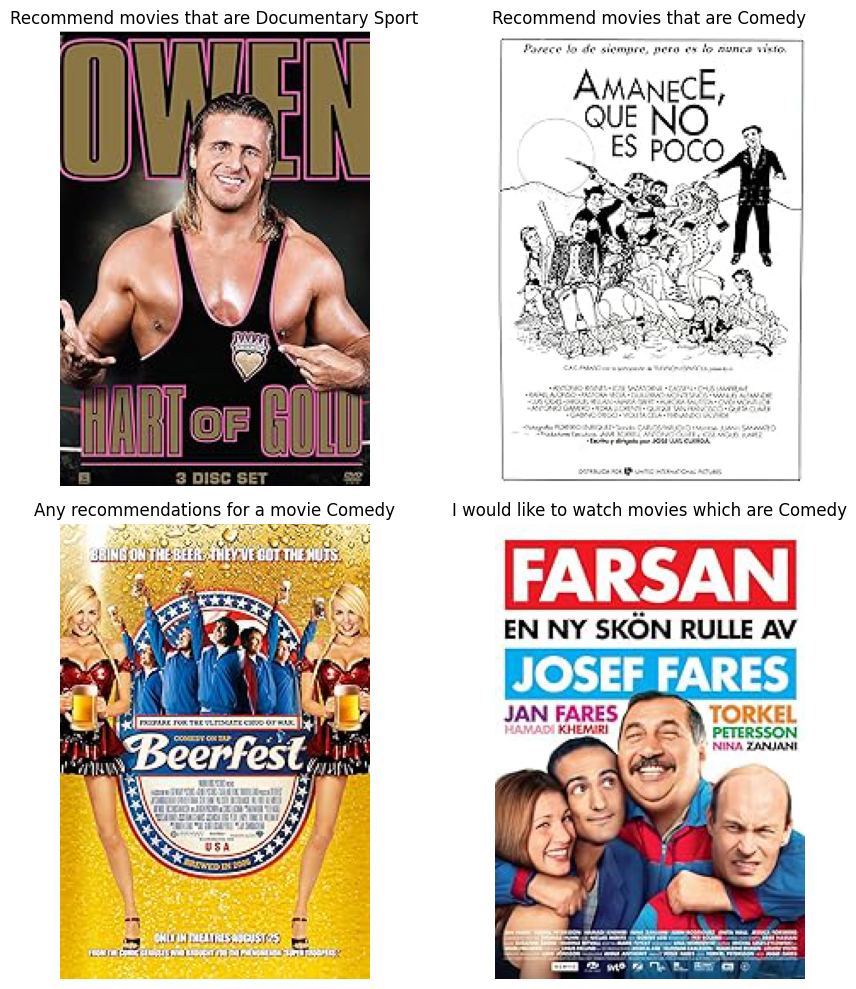

In [54]:
matches = [val_images_url[idx] for idx in indices]
matches_genre = [val_genre[idx] for idx in indices]
print(f"User Query>>>>> {query}")

_, axes = plt.subplots(2, 2, figsize=(10, 10))

for m, g, ax in zip(matches, matches_genre, axes.flatten()):
  img_https_link = 'https://images-na.ssl-images-amazon.com/images/M/' + m.split('/')[-1]
  image = Image.open(requests.get(img_https_link, stream=True).raw).convert('RGB')
  ax.imshow(image)
  ax.set_title(g)
  ax.axis("off")

plt.tight_layout()
plt.show()

ARCHIVE

In [ ]:
class CLIPLightning(pl.LightningModule):
    def __init__(self, image_embedding=2048, text_embedding=768, temperature=1.0):
        super().__init__()
        self.clip_model = CLIPModel(image_embedding, text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        return self.clip_model(batch)

    def training_step(self, batch, batch_idx):
        text_embeddings, image_embeddings = self(batch)
        loss = loss_fn(text_embeddings, image_embeddings, self.temperature)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        text_embeddings, image_embeddings = self(batch)
        loss = loss_fn(text_embeddings, image_embeddings, self.temperature)
        self.log('val_loss', loss)
        return loss

    def training_epoch_end(self,outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()

        print("****Training****")
        print(f'Epoch {self.current_epoch}: Train loss {loss}')

    def validation_epoch_end(self,outputs):
          loss = torch.stack([x for x in outputs]).mean()

          print("****Validation****")
          print(f'Epoch {self.current_epoch}: Validation loss {loss}')

    def configure_optimizers(self):
        params = [
            {"params": self.clip_model.image_encoder.parameters(), "lr": 1e-4},
            {"params": self.clip_model.text_encoder.parameters(), "lr": 1e-5},
            {"params": itertools.chain(
                self.clip_model.image_projection.parameters(), self.clip_model.text_projection.parameters()
            ), "lr": 1e-3, "weight_decay": 1e-3}
        ]
        optimizer = torch.optim.AdamW(params, weight_decay=0.)
        return optimizer

In [ ]:
pl.seed_everything(1234)
my_clip = CLIPLightning().to('cuda')

trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=2, logger= [CSVLogger(save_dir="logs/")],
                    callbacks=[LearningRateMonitor(logging_interval="step")])
trainer.fit(my_clip,train_dataloader ,val_dataloader)